## Top 5 countries per year (by Losses and by Complaints)

In [1]:
import pandas as pd
import numpy as np

# ---------- Safety: rebuild long_df if you skipped earlier cells ----------
if 'long_df' not in globals():
    PATH = "LossFromNetCrime(original).csv"
    df = pd.read_csv(PATH)
    df['Country'] = df['Country'].fillna('Unknown')
    num_cols = [c for c in df.columns if c.endswith('_Complaints') or c.endswith('_Losses')]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='raise')
    years = [2019, 2020, 2021, 2022, 2023, 2024]
    long_df = pd.concat([
        pd.DataFrame({
            'Country': df['Country'],
            'Year': y,
            'Complaints': df[f'{y}_Complaints'],
            'Losses': df[f'{y}_Losses']
        }) for y in years
    ], ignore_index=True)

# Helper function: return the top 5 countries per Year for a metric ('Losses' or 'Complaints')
def top5_by_metric(long_df, metric):
    # Keep just Year / Country / metric we care about
    tmp = long_df[['Year', 'Country', metric]].copy()
    # Sort so the largest values are first within each year
    tmp = tmp.sort_values(['Year', metric], ascending=[True, False])
    # Take the first 5 rows per year (that's the top 5)
    tmp = tmp.groupby('Year', as_index=False).head(5)
    # Make a 1..5 Rank inside each year
    tmp['Rank'] = tmp.groupby('Year')[metric].rank(method='first', ascending=False).astype(int)
    # Nice order of columns
    tmp = tmp.sort_values(['Year', 'Rank'])[['Year', 'Rank', 'Country', metric]]
    return tmp

top5_losses      = top5_by_metric(long_df, 'Losses').assign(Losses_B=lambda d: d['Losses']/1e9)
top5_complaints  = top5_by_metric(long_df, 'Complaints').assign(Complaints_M=lambda d: d['Complaints']/1e6)

print("Top 5 countries by LOSSES (raw + billions for readability):")
print(top5_losses.head(15))   # first 3 years shown; remove .head(15) to print all

print("\nTop 5 countries by COMPLAINTS (raw + millions for readability):")
print(top5_complaints.head(15))  # first 3 years shown; remove .head(15) to print all

# Save for Power BI (both raw and readable units included)
top5_losses.to_csv('top5_losses_by_year.csv', index=False)
top5_complaints.to_csv('top5_complaints_by_year.csv', index=False)
print("\nSaved: top5_losses_by_year.csv, top5_complaints_by_year.csv")


Top 5 countries by LOSSES (raw + billions for readability):
     Year  Rank Country      Losses  Losses_B
49   2019     1      US  3302744547  3.302745
35   2019     2      CN  2532007781  2.532008
17   2019     3      RU  2404940557  2.404941
42   2019     4      DE  1559415577  1.559416
60   2019     5      GB  1342411802  1.342412
166  2020     1      US  3906715208  3.906715
152  2020     2      CN  3061083799  3.061084
159  2020     3      DE  2432407746  2.432408
134  2020     4      RU  2402832265  2.402832
177  2020     5      GB  1590816673  1.590817
283  2021     1      US  6466618579  6.466619
251  2021     2      RU  5932226222  5.932226
269  2021     3      CN  5067323422  5.067323
294  2021     4      GB  2740678986  2.740679
281  2021     5      UA  2590458387  2.590458

Top 5 countries by COMPLAINTS (raw + millions for readability):
     Year  Rank Country  Complaints  Complaints_M
35   2019     1      CN      449305      0.449305
49   2019     2      US      428355    

## Year to year changes as bar charts (raw amounts)

We show how much totals changed from one year to the next using actual amounts.

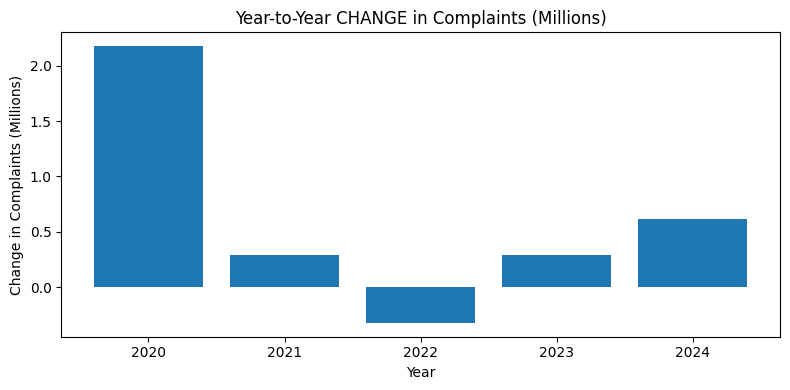

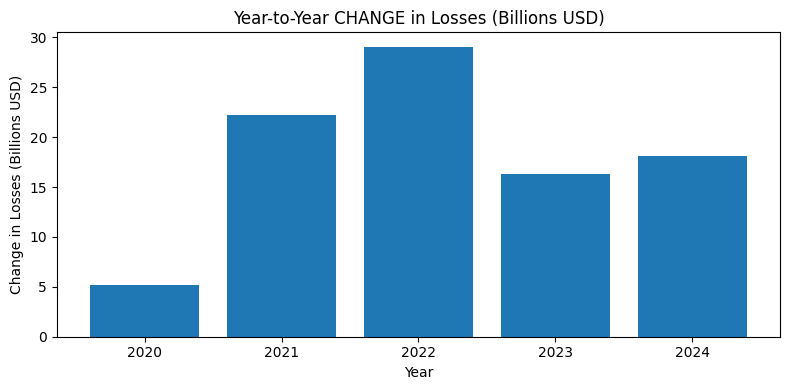

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------- Safety: rebuild yearly totals if missing ----------
if 'yearly' not in globals():
    yearly = long_df.groupby('Year', as_index=True).agg(
        Complaints=('Complaints', 'sum'),
        Losses=('Losses', 'sum')
    )

# Add readable units (still raw amounts)
yearly_units = yearly.assign(
    Complaints_M = yearly['Complaints'] / 1_000_000,      # complaints in millions
    Losses_B     = yearly['Losses'] / 1_000_000_000       # losses in billions
)

# Compute year-to-year differences (current year - previous year)
deltas = yearly_units[['Complaints_M', 'Losses_B']].diff().dropna()

# ---- Bar chart for Complaints: year-over-year change in **millions** ----
plt.figure(figsize=(8,4))
plt.bar(deltas.index.astype(str), deltas['Complaints_M'])
plt.title('Year-to-Year CHANGE in Complaints (Millions)')
plt.xlabel('Year')
plt.ylabel('Change in Complaints (Millions)')
plt.tight_layout()
plt.show()

# ---- Bar chart for Losses: year-over-year change in **billions USD** ----
plt.figure(figsize=(8,4))
plt.bar(deltas.index.astype(str), deltas['Losses_B'])
plt.title('Year-to-Year CHANGE in Losses (Billions USD)')
plt.xlabel('Year')
plt.ylabel('Change in Losses (Billions USD)')
plt.tight_layout()
plt.show()


## Correlation Complaints vs Losses by Year (bar chart)

Correlation is unitless (between −1 and +1). Close to +1 means “countries with more complaints also tend to report more losses” within that year.

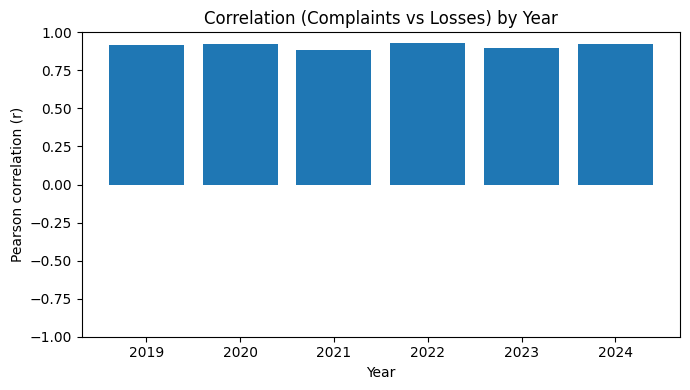

Per-year correlation (Complaints vs Losses):
Year
2019    0.918
2020    0.920
2021    0.883
2022    0.929
2023    0.894
2024    0.925
Name: (Complaints, Losses), dtype: float64


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Compute correlation per year (cross-section of countries within each year)
per_year_corr = (
    long_df.groupby('Year')[['Complaints','Losses']]
           .corr()
           .unstack()
           .iloc[:,1]          # the Complaints vs Losses cell
           .sort_index()
)

# Bar chart of correlation by year
plt.figure(figsize=(7,4))
plt.bar(per_year_corr.index.astype(str), per_year_corr.values)
plt.ylim(-1, 1)   # full possible range of correlation
plt.title('Correlation (Complaints vs Losses) by Year')
plt.xlabel('Year')
plt.ylabel('Pearson correlation (r)')
plt.tight_layout()
plt.show()

# Print the exact numbers for your report
print("Per-year correlation (Complaints vs Losses):")
print(per_year_corr.round(3))


## Reworked prediction model - train on 2019 - 2024 predict for 2025 only

To forecast 2025 without going past 2025, we’ll use an autoregressive panel model:

Predict Losses_t from Losses_(t−1), Complaints_(t−1), and a simple year trend.

Train it on all available years that have a valid “previous year” (so 2020–2024 target years use 2019–2023 lags).

Then forecast 2025 for each country using its 2024 values as the lags.

This uses plain Linear Regression on the log of losses (makes money data more stable). We never predict past 2025.

In [4]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# 1) Build lag features per country
panel = long_df.sort_values(['Country','Year']).copy()
panel['Losses_lag1']     = panel.groupby('Country')['Losses'].shift(1)
panel['Complaints_lag1'] = panel.groupby('Country')['Complaints'].shift(1)
panel['YearOffset']      = panel['Year'] - panel['Year'].min()  # 0,1,2,...

# 2) Keep rows where we have the lags (so targets 2020..2024)
train_rows = panel['Year'].between(2020, 2024) & panel[['Losses_lag1','Complaints_lag1']].notna().all(axis=1)
train_df = panel.loc[train_rows, ['Country','Year','Losses','Losses_lag1','Complaints_lag1','YearOffset']].copy()

# Features (inputs) and target for training (2019-2024 info condensed via lags)
X_train = pd.DataFrame({
    'log1p_Losses_lag1'    : np.log1p(train_df['Losses_lag1']),
    'log1p_Complaints_lag1': np.log1p(train_df['Complaints_lag1']),
    'YearOffset'           : train_df['YearOffset']
})
y_train = np.log1p(train_df['Losses'])  # log(1 + current year's losses)

# 3) Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# 4) Build 2025 prediction set:
#    For each country, take its 2024 values as lags to predict 2025.
last_year = 2024
base_2024 = panel[panel['Year'] == last_year][['Country','Losses','Complaints']]
base_2024 = base_2024.rename(columns={'Losses':'Losses_lag1', 'Complaints':'Complaints_lag1'})
future_2025 = base_2024.copy()
future_2025['Year']       = 2025
future_2025['YearOffset'] = 2025 - panel['Year'].min()

# Make features for 2025
X_2025 = pd.DataFrame({
    'log1p_Losses_lag1'    : np.log1p(future_2025['Losses_lag1']),
    'log1p_Complaints_lag1': np.log1p(future_2025['Complaints_lag1']),
    'YearOffset'           : future_2025['YearOffset']
})

# 5) Predict log-losses for 2025, then convert back to dollars
log_pred_2025 = model.predict(X_2025)
future_2025['Predicted_Losses_2025'] = np.expm1(log_pred_2025)

# Add readable units and a helpful delta vs 2024
future_2025['Predicted_Losses_2025_B'] = future_2025['Predicted_Losses_2025'] / 1e9
future_2025['Delta_vs_2024']           = future_2025['Predicted_Losses_2025'] - future_2025['Losses_lag1']
future_2025['Delta_vs_2024_B']         = future_2025['Delta_vs_2024'] / 1e9

# Sort by largest predicted 2025 losses
pred_2025_by_country = future_2025[['Country','Predicted_Losses_2025','Predicted_Losses_2025_B','Delta_vs_2024','Delta_vs_2024_B']].sort_values('Predicted_Losses_2025', ascending=False)

print("2025 predictions — top 10 countries by predicted losses (billions shown for readability):")
print(pred_2025_by_country.head(10).round({'Predicted_Losses_2025_B':2, 'Delta_vs_2024_B':2}))

# Also compute the global total for 2025
total_pred_2025 = pred_2025_by_country['Predicted_Losses_2025'].sum()
print(f"\nTotal predicted LOSSES for 2025 (all countries): ${total_pred_2025:,.0f}")

# 6) Save predictions for Power BI / reporting
pred_2025_by_country.to_csv('predicted_losses_2025_by_country.csv', index=False)
print("Saved: predicted_losses_2025_by_country.csv")


2025 predictions — top 10 countries by predicted losses (billions shown for readability):
    Country  Predicted_Losses_2025  Predicted_Losses_2025_B  Delta_vs_2024  \
634      US           1.889654e+10                    18.90   4.439527e+09   
620      CN           1.518510e+10                    15.19   3.885979e+09   
602      RU           1.265156e+10                    12.65   1.489781e+09   
645      GB           8.543513e+09                     8.54   2.164399e+09   
627      DE           5.935643e+09                     5.94   6.561568e+08   
632      UA           5.917342e+09                     5.92   7.560054e+08   
610      SG           5.314943e+09                     5.31   7.904068e+08   
644      FR           5.047299e+09                     5.05   1.021639e+09   
659      IN           4.547694e+09                     4.55   3.832902e+08   
667      JP           4.281082e+09                     4.28   8.875360e+08   

     Delta_vs_2024_B  
634             4.44  
620  

## Simple chart to present the 2025 forecast

This overlays actual totals (2019–2024) with the predicted total for 2025.

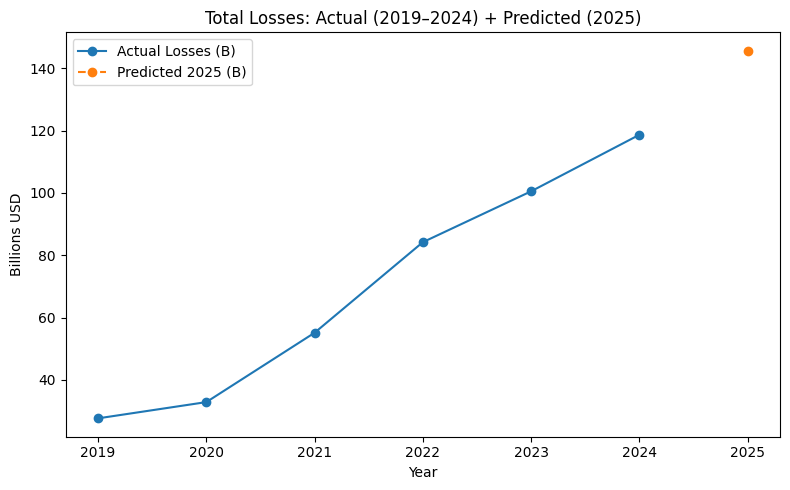

In [5]:
import matplotlib.pyplot as plt

# Build a series with actual totals 2019..2024 and the predicted total for 2025
yearly_actual_B = long_df.groupby('Year')['Losses'].sum() / 1e9
total_2025_B    = total_pred_2025 / 1e9

years_plot  = list(yearly_actual_B.index) + [2025]
values_plot = list(yearly_actual_B.values) + [total_2025_B]

plt.figure(figsize=(8,5))
plt.plot(years_plot[:-1], values_plot[:-1], marker='o', label='Actual Losses (B)')
plt.plot([2025], [total_2025_B], marker='o', linestyle='--', label='Predicted 2025 (B)')
plt.title('Total Losses: Actual (2019–2024) + Predicted (2025)')
plt.xlabel('Year')
plt.ylabel('Billions USD')
plt.legend()
plt.tight_layout()
plt.show()


## Additional Narrowed Prediction based on Top 5 Countries (by complaints and losses)

Top 5 by Losses    : ['US', 'RU', 'CN', 'GB', 'DE']
Top 5 by Complaints: ['US', 'CN', 'GB', 'RU', 'HK']


C:\Users\Administrator\AppData\Local\Temp\1\ipykernel_14524\4165076784.py:95: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pred_2025_B = float(pred_row['Predicted_Losses_2025'] / 1e9)


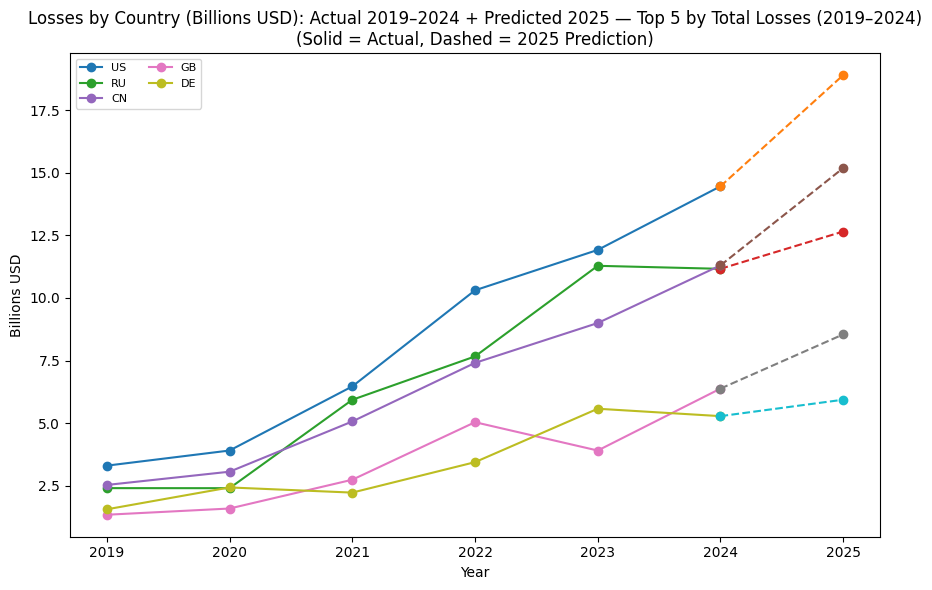

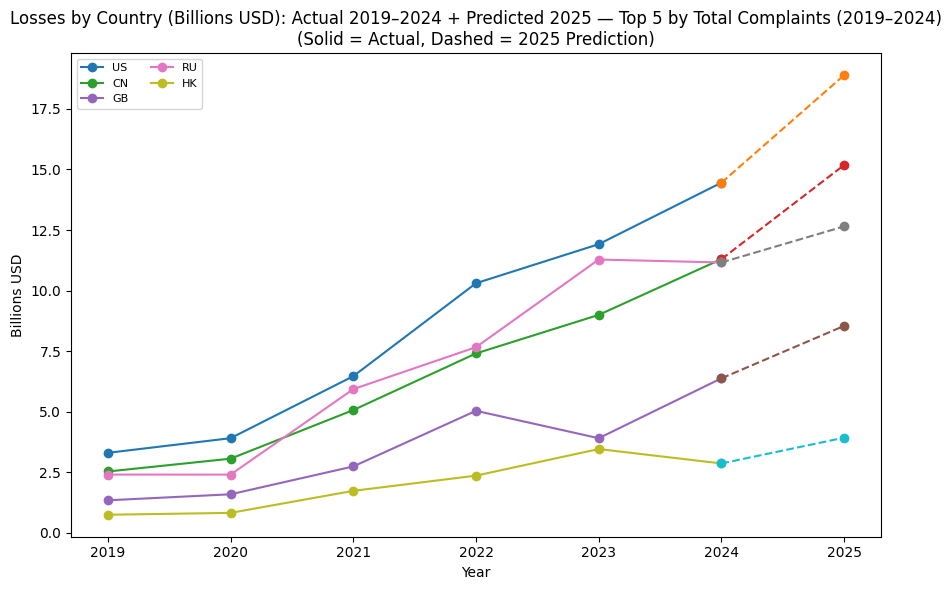

In [10]:
# === LINE PLOTS: Top-5 countries, separate line per country ===
# Solid = Actual 2019–2024; Dashed segment -> 2025 prediction.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# ---- Safety: rebuild long_df if missing ----
if 'long_df' not in globals():
    PATH = "LossFromNetCrime(original).csv"
    df = pd.read_csv(PATH)
    df['Country'] = df['Country'].fillna('Unknown')
    num_cols = [c for c in df.columns if c.endswith('_Complaints') or c.endswith('_Losses')]
    for c in num_cols:
        df[c] = pd.to_numeric(df[c], errors='raise')
    years = [2019, 2020, 2021, 2022, 2023, 2024]
    long_df = pd.concat([
        pd.DataFrame({
            'Country': df['Country'],
            'Year': y,
            'Complaints': df[f'{y}_Complaints'],
            'Losses': df[f'{y}_Losses']
        }) for y in years
    ], ignore_index=True)

# ---- Find Top-5 by totals (2019–2024) ----
totals_by_country = long_df.groupby('Country', as_index=False).agg(
    Total_Complaints=('Complaints', 'sum'),
    Total_Losses=('Losses', 'sum')
)
top5_by_losses = totals_by_country.nlargest(5, 'Total_Losses')['Country'].tolist()
top5_by_complaints = totals_by_country.nlargest(5, 'Total_Complaints')['Country'].tolist()

print("Top 5 by Losses    :", top5_by_losses)
print("Top 5 by Complaints:", top5_by_complaints)

# ---- Ensure 2025 predictions exist (lag-1 model: Losses_t ~ Losses_{t-1}, Complaints_{t-1}, YearOffset) ----
need_predictions = ('future_2025' not in globals()) or ('Predicted_Losses_2025' not in locals() and 'Predicted_Losses_2025' not in long_df.columns)

if need_predictions:
    panel = long_df.sort_values(['Country', 'Year']).copy()
    panel['Losses_lag1']     = panel.groupby('Country')['Losses'].shift(1)
    panel['Complaints_lag1'] = panel.groupby('Country')['Complaints'].shift(1)
    panel['YearOffset']      = panel['Year'] - panel['Year'].min()  # 0,1,2,...

    # Train targets 2020..2024 (have 2019..2023 lags)
    train_mask = panel['Year'].between(2020, 2024) & panel[['Losses_lag1','Complaints_lag1']].notna().all(axis=1)
    train_df = panel.loc[train_mask, ['Country','Year','Losses','Losses_lag1','Complaints_lag1','YearOffset']].copy()

    X_train = pd.DataFrame({
        'log1p_Losses_lag1'    : np.log1p(train_df['Losses_lag1']),
        'log1p_Complaints_lag1': np.log1p(train_df['Complaints_lag1']),
        'YearOffset'           : train_df['YearOffset']
    })
    y_train = np.log1p(train_df['Losses'])

    model = LinearRegression()
    model.fit(X_train, y_train)

    # Build 2025 rows from 2024 values (lag-1)
    base_2024 = panel[panel['Year'] == 2024][['Country','Losses','Complaints']].rename(
        columns={'Losses':'Losses_lag1', 'Complaints':'Complaints_lag1'}
    )
    future_2025 = base_2024.copy()
    future_2025['Year']       = 2025
    future_2025['YearOffset'] = 2025 - panel['Year'].min()

    X_2025 = pd.DataFrame({
        'log1p_Losses_lag1'    : np.log1p(future_2025['Losses_lag1']),
        'log1p_Complaints_lag1': np.log1p(future_2025['Complaints_lag1']),
        'YearOffset'           : future_2025['YearOffset']
    })

    log_pred_2025 = model.predict(X_2025)
    future_2025['Predicted_Losses_2025'] = np.expm1(log_pred_2025)

# ---- Helper to draw one chart for a given top-5 list ----
def plot_top5_lines(top_countries, title_suffix):
    plt.figure(figsize=(9,6))

    for country in top_countries:
        # Actual 2019–2024
        df_c = long_df[(long_df['Country'] == country) & (long_df['Year'].between(2019, 2024))] \
               .sort_values('Year')
        years_actual = df_c['Year'].tolist()                         # [2019, ..., 2024]
        values_actual_B = (df_c['Losses'] / 1e9).tolist()           # billions

        # Solid actual line
        plt.plot(years_actual, values_actual_B, marker='o', label=country)

        # Dashed segment to the predicted 2025 point (if we have it)
        pred_row = future_2025[future_2025['Country'] == country]
        if not pred_row.empty:
            pred_2025_B = float(pred_row['Predicted_Losses_2025'] / 1e9)
            last_year = years_actual[-1]
            last_val  = values_actual_B[-1]
            # Draw a short dashed line from 2024 actual to 2025 predicted
            plt.plot([last_year, 2025], [last_val, pred_2025_B], marker='o', linestyle='--', label='_nolegend_')

    plt.title(f'Losses by Country (Billions USD): Actual 2019–2024 + Predicted 2025 — {title_suffix}\n'
              f'(Solid = Actual, Dashed = 2025 Prediction)')
    plt.xlabel('Year')
    plt.ylabel('Billions USD')
    plt.legend(ncol=2, fontsize=8)   # countries only (dashed segments hidden from legend)
    plt.tight_layout()
    plt.show()

# ---- Plot the two charts ----
plot_top5_lines(top5_by_losses,     'Top 5 by Total Losses (2019–2024)')
plot_top5_lines(top5_by_complaints, 'Top 5 by Total Complaints (2019–2024)')


## Block Chart (bar chart) of TOTAL complaints and losses:

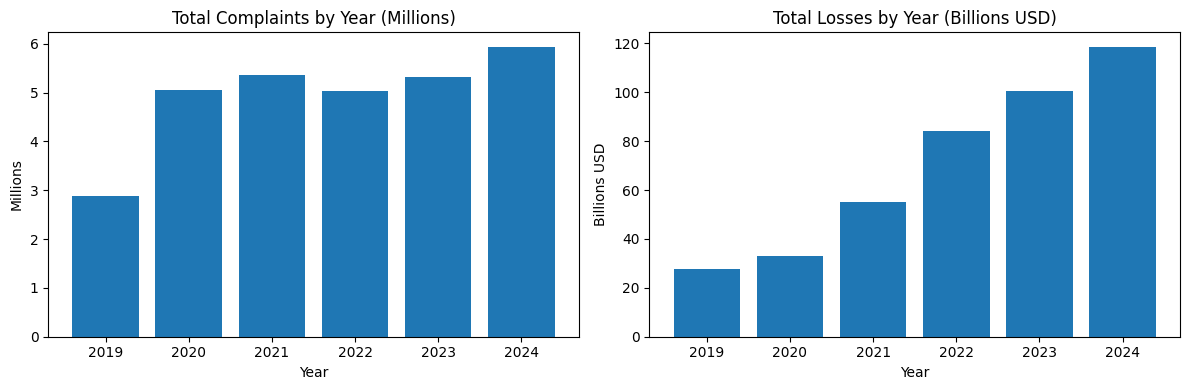

In [7]:
# Build yearly totals if missing
if 'yearly' not in globals():
    yearly = long_df.groupby('Year', as_index=True).agg(
        Complaints=('Complaints','sum'),
        Losses=('Losses','sum')
    )

import matplotlib.pyplot as plt

# Use readable units but still raw amounts (no percentages)
yearly_plot = yearly.assign(
    Complaints_M = yearly['Complaints'] / 1_000_000,
    Losses_B     = yearly['Losses'] / 1_000_000_000
)

fig, axes = plt.subplots(1, 2, figsize=(12,4))

# Left: Complaints totals per year (millions)
axes[0].bar(yearly_plot.index.astype(str), yearly_plot['Complaints_M'])
axes[0].set_title('Total Complaints by Year (Millions)')
axes[0].set_xlabel('Year'); axes[0].set_ylabel('Millions')

# Right: Losses totals per year (billions)
axes[1].bar(yearly_plot.index.astype(str), yearly_plot['Losses_B'])
axes[1].set_title('Total Losses by Year (Billions USD)')
axes[1].set_xlabel('Year'); axes[1].set_ylabel('Billions USD')

plt.tight_layout()
plt.show()
